## Predict St Lucia Metal Roofs

Using rotated to hz + OpenCv border


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join
from ipyexperiments import *

In [3]:
torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [4]:
data_dir = Path('data')


In [5]:
MODEL_NAME='result_QC'

In [6]:
NB_NUM='10_0'
RUN='0'

In [7]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: 2933e0a1, DATE: 20191125


In [8]:
#DATE = '20191124'
#UID = '1328c588'

In [9]:
SUB_NUM='2'

In [10]:
img_size=256
bs=128

In [11]:
train_images=data_dir/f'train/rotated/clipped/{img_size}'
test_images=data_dir/f'test/rotated/clipped/{img_size}'

#### concat predictions

In [12]:
list_ = []
data_folder = data_dir/'processing/Test_Pred_Raw_Train_Data/'
for file_ in os.listdir(data_folder):
    df = pd.read_csv(data_folder/f'{file_}')
    pfix=file_.split('stage-2-')[1]
    df['model']=pfix.split('-')[0]
    pfix=pfix.split('metal-only_')[1]
    run=pfix.split('-')[0]
    df['run']=run
    ttype=pfix.split(f'{run}-')[1].split('-')[0]
    df['ttype']=ttype
    df['uid']=file_
    list_.append(df)
df_sl_metal = pd.concat(list_)

In [13]:
df_sl_metal.head()

,id,healthy_metal,irregular_metal,model,run,ttype,uid
0,7a4d630a,0.892201,0.009360,rn152,0,region,stage-2-rn152-10_metal-only_0-region-5-2019112...
1,7a4bbbd6,0.974252,0.016870,rn152,0,region,stage-2-rn152-10_metal-only_0-region-5-2019112...
2,7a4ac744,0.267454,0.559205,rn152,0,region,stage-2-rn152-10_metal-only_0-region-5-2019112...
3,7a4881fa,0.031138,0.760786,rn152,0,region,stage-2-rn152-10_metal-only_0-region-5-2019112...
4,7a4aa4a8,0.415445,0.454183,rn152,0,region,stage-2-rn152-10_metal-only_0-region-5-2019112...


In [14]:
def get_all_model_type(model, ttype, runs):
    df = df_sl_metal.loc[(df_sl_metal['model'] == model) & (df_sl_metal['ttype']== ttype)& df_sl_metal['run'].isin(runs)]
    df=df[['healthy_metal','irregular_metal']]
    classes=df.idxmax(axis=1)
    df['roof_material']=classes
    return df

In [15]:
def print_lengths(ls):
    for l in ls:
        print(len(l))

In [16]:
def plot_df_types(df1, df2, df3):
    ax = df1.roof_material.value_counts().plot(kind='bar', color='blue', width=.75, legend=True, alpha=0.2)
    ax1 = df2.roof_material.value_counts().plot(kind='bar', color='green', width=.5, legend=True, alpha=0.2)
    df3.roof_material.value_counts().plot(kind='bar', color='maroon', width=.25, alpha=0.5, legend=True)

In [17]:
df_binary_rn50 = get_all_model_type('rn50', 'binary', ['0'])
df_region_rn50 = get_all_model_type('rn50', 'region', ['0'])
df_country_rn50 = get_all_model_type('rn50', 'country', ['0'])

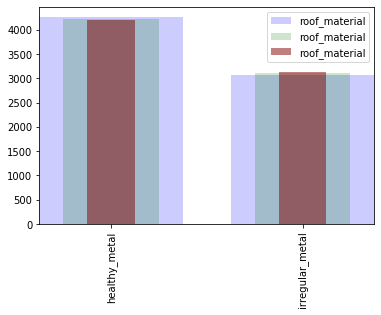

In [18]:
plot_df_types(df_binary_rn50, df_region_rn50, df_country_rn50)

In [19]:
print_lengths([df_binary_rn50, df_region_rn50, df_country_rn50])

7325
7325
7325


In [20]:
df_binary_rn152 = get_all_model_type('rn152', 'binary', ['0'])
df_region_rn152 = get_all_model_type('rn152', 'region', ['0'])
df_country_rn152 = get_all_model_type('rn152', 'country', ['0'])

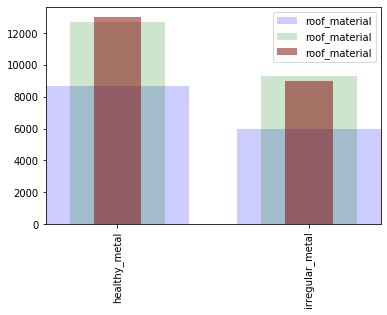

In [21]:
plot_df_types(df_binary_rn152, df_region_rn152, df_country_rn152)

In [22]:
print_lengths([df_binary_rn152, df_region_rn152, df_country_rn152])

14650
21975
21975


In [23]:
df_binary_dn121 = get_all_model_type('dn121', 'binary', ['0'])
df_region_dn121 = get_all_model_type('dn121', 'region', ['0'])
df_country_dn121 = get_all_model_type('dn121', 'country', ['0'])

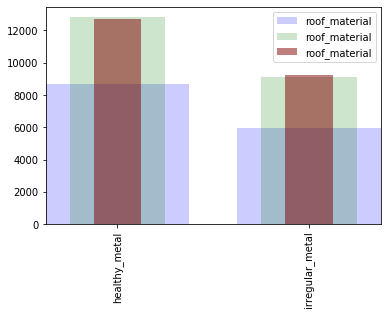

In [24]:
plot_df_types(df_binary_dn121, df_region_dn121, df_country_dn121)

In [25]:
print_lengths([df_binary_dn121, df_region_dn121, df_country_dn121])

14650
21975
21975


In [26]:
#### Healthy metal

In [27]:
df_hm=df_sl_metal[['id','healthy_metal']]

In [28]:
len(df_hm)

373575

In [29]:
result = df_hm.groupby(['id'], as_index=False).agg(
                     ['mean', 'std'])

In [30]:
len(result)

7325

In [31]:
result.head()

healthy_metal          
                  mean       std
id                              
7a44da50      0.993236  0.004211
7a44db72      0.980760  0.015458
7a44dc08      0.077523  0.043024
7a44dc80      0.349815  0.127981
7a44dcf8      0.612397  0.168109

Sort by tuple

In [32]:
result.sort_values(by=('healthy_metal','std'),ascending=False).head()

healthy_metal          
                  mean       std
id                              
7a4e4a22      0.597232  0.339870
7a47123e      0.433977  0.338055
7a486b48      0.321523  0.326643
7a5156fe      0.416499  0.307607
7a50a524      0.498565  0.307309

Or drop header

In [33]:
result.columns = result.columns.droplevel(0)

In [34]:
result.head()

,mean,std
id,,
7a44da50,0.993236,0.004211
7a44db72,0.980760,0.015458
7a44dc08,0.077523,0.043024
7a44dc80,0.349815,0.127981
7a44dcf8,0.612397,0.168109


In [35]:
result=result.sort_values(by=('std'),ascending=False).reset_index()

In [36]:
result.head()

,id,mean,std
0,7a4e4a22,0.597232,0.339870
1,7a47123e,0.433977,0.338055
2,7a486b48,0.321523,0.326643
3,7a5156fe,0.416499,0.307607
4,7a50a524,0.498565,0.307309


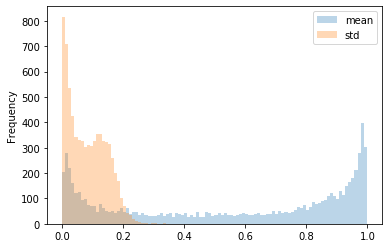

In [37]:
result.plot.hist(bins=100, alpha=0.3)

Try as first pass using 0.8 mean as cutoff

In [38]:
hm_10pct_stddev=result.loc[result['std'] <= 0.1]
hm_20pct_stddev=result.loc[result['std'] <= 0.2]

In [39]:
hm_80pct_plus=result.loc[result['mean'] >= 0.8]
hm_70pct_plus=result.loc[result['mean'] >= 0.7]

In [40]:
len(hm_80pct_plus)/len(result)

0.3968600682593857

#### Irregular metal

In [41]:
df_im=df_sl_metal[['id','irregular_metal']]

In [42]:
result_im = df_im.groupby(['id'], as_index=False).agg(
                     ['mean', 'std'])

In [43]:
result_im.columns = result_im.columns.droplevel(0)

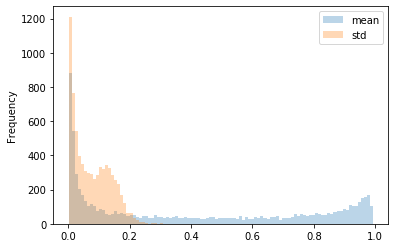

In [44]:
result_im.plot.hist(bins=100, alpha=0.3)

In [45]:
im_10pct_stddev=result_im.loc[result_im['std'] <= 0.1]
im_20pct_stddev=result_im.loc[result_im['std'] <= 0.2]

In [46]:
im_80pct_plus=result_im.loc[result_im['mean'] >= 0.8]
im_70pct_plus=result_im.loc[result_im['mean'] >= 0.7]

In [47]:
len(im_80pct_plus)/len(result_im)

0.24313993174061432

#### Save these as 'silver' validated

In [48]:
im_10pct_stddev['roof_type']= 'irregular_metal'
im_20pct_stddev['roof_type']= 'irregular_metal'

hm_10pct_stddev['roof_type']= 'healthy_metal'
hm_20pct_stddev['roof_type']= 'healthy_metal'

/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [49]:
im_80pct_plus['roof_type']= 'irregular_metal'
hm_80pct_plus['roof_type']= 'healthy_metal'

/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [50]:
im_70pct_plus['roof_type']= 'irregular_metal'
hm_70pct_plus['roof_type']= 'healthy_metal'

/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [51]:
im_80pct_plus.head()

,mean,std,roof_type
id,,,
7a44dc08,0.917674,0.043019,irregular_metal
7a44dd66,0.979412,0.009549,irregular_metal
7a44ddde,0.931887,0.041816,irregular_metal
7a44de60,0.920796,0.031312,irregular_metal
7a44dece,0.886574,0.113696,irregular_metal


In [52]:
im_80pct_plus.drop(columns=['mean','std'],inplace=True)
hm_80pct_plus.drop(columns=['mean','std'],inplace=True)
im_70pct_plus.drop(columns=['mean','std'],inplace=True)
hm_70pct_plus.drop(columns=['mean','std'],inplace=True)

im_10pct_stddev.drop(columns=['mean','std'],inplace=True)
im_20pct_stddev.drop(columns=['mean','std'],inplace=True)
hm_10pct_stddev.drop(columns=['mean','std'],inplace=True)
hm_20pct_stddev.drop(columns=['mean','std'],inplace=True)

/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [53]:
silver_val_80pct_rooftypes=im_80pct_plus.append(hm_80pct_plus).reset_index()
silver_val_70pct_rooftypes=im_70pct_plus.append(hm_70pct_plus).reset_index()

silver_val_10pct_std_rooftypes=im_10pct_stddev.append(hm_10pct_stddev).reset_index()
silver_val_20pct_std_rooftypes=im_20pct_stddev.append(hm_20pct_stddev).reset_index()

/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [54]:
silver_val_80pct_rooftypes = silver_val_80pct_rooftypes.rename(columns={'index': 'id', 'id': 'drop'})
silver_val_70pct_rooftypes = silver_val_70pct_rooftypes.rename(columns={'index': 'id', 'id': 'drop'})

silver_val_10pct_std_rooftypes=silver_val_10pct_std_rooftypes.rename(columns={'index': 'id', 'id': 'drop'})
silver_val_20pct_std_rooftypes=silver_val_20pct_std_rooftypes.rename(columns={'index': 'id', 'id': 'drop'})

In [55]:
silver_val_80pct_rooftypes.drop(columns=['drop'],inplace=True)
silver_val_70pct_rooftypes.drop(columns=['drop'],inplace=True)

silver_val_10pct_std_rooftypes.drop(columns=['drop'],inplace=True)
silver_val_20pct_std_rooftypes.drop(columns=['drop'],inplace=True)

In [56]:
len(silver_val_80pct_rooftypes)

4688

In [57]:
len(silver_val_70pct_rooftypes)

5678

these should not be > dataset length, dont use for now

In [58]:
len(silver_val_10pct_std_rooftypes)

9070

In [59]:
len(silver_val_20pct_std_rooftypes)

14274

In [60]:
len(df_sl_metal)

373575

In [61]:
silver_val_80pct_rooftypes.to_csv(data_dir/'st_lucia_test_80pct_silver_healthy_irregular_metal.csv', index=False)
silver_val_70pct_rooftypes.to_csv(data_dir/'st_lucia_test_70pct_silver_healthy_irregular_metal.csv', index=False)

#silver_val_10pct_std_rooftypes.to_csv(data_dir/'st_lucia_silver_10pct_std_dev_healthy_irregular_metal.csv', index=False)
#silver_val_20pct_std_rooftypes.to_csv(data_dir/'st_lucia_silver_20pct_std_dev_healthy_irregular_metal.csv', index=False)